# Business Problem 
In the energy sector, utility companies and grid operators face significant challenges in accurately forecasting electricity load demand due to fluctuating factors such as weather patterns, seasonal variations, economic activities, and the increasing integration of renewable energy sources. Inaccurate forecasts can lead to inefficient resource allocation, grid instability, higher operational costs, and potential blackouts or overproduction waste. For instance, underestimating demand might result in reliance on expensive peaker plants, while overestimation wastes generated power. This problem is exacerbated in multi-country or regional scenarios, where demand patterns vary by geography, and day-ahead price forecasting is critical for market optimization. A robust forecasting system is essential to enable proactive grid management, cost reduction, and sustainable energy distribution.

# Project Goals
To demonstrate expertise in building scalable, production-ready machine learning pipelines for time series forecasting, the primary goals of this repository are:

1. Develop a Comprehensive Load Forecasting Pipeline: Create an end-to-end Jupyter notebook that processes real-world energy data from Open Power System Data, incorporating feature engineering (e.g., temporal lags, rolling statistics), multiple modeling approaches (LightGBM for gradient boosting, SARIMAX for statistical forecasting, and Persistence as a baseline), and probabilistic forecasting using quantile regression to handle uncertainty.
Achieve High Model Accuracy and Robustness: Implement cross-validation techniques (TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, and train_test_split) to evaluate models, aiming for MAE below 3% of average load (e.g., ~1,000-3,000 MW for typical European grids) and RMSE under 4,000 MW, ensuring generalizability across datasets and countries (DE, FR, GB).

2. Incorporate MLOps Best Practices: Use MLflow for experiment tracking, model logging with input signatures, and metric logging (e.g., MAE, RMSE, pinball loss), enabling reproducible workflows and seamless deployment—key for big tech environments like AWS SageMaker or Google Cloud AI.
Provide Actionable Insights through Visualizations: Generate at least six interactive and diagnostic plots (e.g., train/test splits, correlation heatmaps, feature importance, residual plots, error histograms, PACF for residuals) to interpret model performance and data patterns, facilitating stakeholder communication.

3. Demonstrate Scalability and Innovation: Extend to multi-country baselines and probabilistic price forecasting, showcasing handling of real-time data challenges and integration of advanced libraries (e.g., statsmodels for SARIMAX, scipy.stats for residual analysis), positioning the solution for large-scale applications in energy trading or smart grids.

In [3]:
"""
Load forecasting pipeline notebook 
Sections:
 A) LightGBM pipeline for Germany (DE) load forecasting
 B) Multi-country baseline evaluation (Top 3 models: Persistence, LightGBM, SARIMAX)
 C) Probabilistic forecasting (Quantile LightGBM) for DE day-ahead price
 Usage: run i
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score,roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
import lightgbm as lgb
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import mlflow.lightgbm

In [4]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

In [5]:

# Set up paths
DATA_DIR = Path('data')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

##2. Data collection

In [ ]:
# Load energy dataset for load forecasting with 15-minute intervals
data_path = DATA_DIR / '/Users/phionanamugga/Documents/coding/datascience/Energy_Projects/time_series_15min_singleindex.csv'
df = pd.read_csv(data_path, parse_dates=['utc_timestamp'], index_col='utc_timestamp')
df = df.tz_convert('Europe/Berlin')  # Assuming CET for Germany 

###2.1 Checking data properties

In [6]:
# checks statistical summary to identify outliers, scale issues, and data spread
df.describe()

,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual,HU_load_actual_entsoe_transparency,HU_load_forecast_entsoe_transparency,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
count,201598.000000,201598.000000,131378.000000,201352.000000,201406.000000,201598.000000,201502.000000,201598.000000,201502.000000,175199.000000,201184.000000,174783.000000,175199.000000,201300.000000,174897.000000,175199.000000,201300.000000,174897.000000,175199.000000,201310.000000,174907.000000,201598.000000,201598.000000,201541.000000,201598.000000,201598.000000,201598.000000,70095.000000,66622.000000,70153.000000,70182.000000,70182.000000,70182.000000,201598.000000,201598.000000,201544.000000,201598.000000,201598.000000,201598.000000,201568.000000,201598.000000,201598.000000,201598.000000,201598.000000,201502.000000,201542.000000,201598.000000,201598.000000,201410.000000,35859.000000,193021.000000,198794.000000,197182.000000,201598.000000,201598.000000,181382.000000,193733.000000,193733.000000,200901.000000
mean,7070.161704,7039.857678,33.947254,135.283656,729.651345,9808.396916,9759.333258,55492.589700,54791.506975,42378.044395,4566.134215,0.101903,39972.675592,11552.324213,0.278910,3261.038893,1970.485356,0.570562,36711.648754,9581.485665,0.254252,10404.480078,9647.294301,1177.358160,3724.278124,255.699935,3468.578189,55565.192955,54938.884982,5007.243484,14372.007450,2802.648798,11569.358652,20943.072669,20977.963388,1051.557426,1857.242329,17184.771520,17220.759995,1692.775088,5725.266998,1715.398402,4009.868597,6960.477815,6950.370428,640.999928,248.046834,4854.167424,4673.943854,177.082384,77.224803,470.611662,489.717953,12578.456013,12809.253119,162.335138,986.695963,340.447829,656.203710
std,1403.676483,1357.674902,16.815854,199.645788,693.810792,1398.512250,1384.276280,10041.148871,9523.623592,4306.349752,6964.591224,0.156266,7262.687183,9080.676730,0.211672,1359.166785,1569.613649,0.393709,5961.363419,7992.062213,0.207110,1967.996822,1849.750672,1850.539532,3289.179932,277.114674,3139.221621,10058.663849,9518.462412,7680.618010,10319.426926,1778.522822,9069.760594,3618.724194,3551.750901,1618.747117,1828.875394,3240.566908,3141.7364

In [7]:
# checks first five records
df.head()

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual,HU_load_actual_entsoe_transparency,HU_load_forecast_entsoe_transparency,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:15:00+01:00,2015-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:30:00+01:00,2015-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:45:00+01:00,2015-01-01T00:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+01:00,2015-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# audit all available features for potential forecasting covariates
df.columns

Index(['cet_cest_timestamp', 'AT_load_actual_entsoe_transparency',
       'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead',
       'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual',
       'BE_load_actual_entsoe_transparency',
       'BE_load_forecast_entsoe_transparency',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_50hertz_load_actual_entsoe_transparency',
       'DE_50hertz_load_forecast_entsoe_transparency',
       'DE_50hertz_solar_generation_actual',
       'DE_50hertz_wind_generation_actual',
       'DE_50hertz_wind_offshore_generation_actu

In [9]:
# Check data types to ensure correct parsing and identify conversion needs
df.dtypes

cet_cest_timestamp                                  object
AT_load_actual_entsoe_transparency                 float64
AT_load_forecast_entsoe_transparency               float64
AT_price_day_ahead                                 float64
AT_solar_generation_actual                         float64
AT_wind_onshore_generation_actual                  float64
BE_load_actual_entsoe_transparency                 float64
BE_load_forecast_entsoe_transparency               float64
DE_load_actual_entsoe_transparency                 float64
DE_load_forecast_entsoe_transparency               float64
DE_solar_capacity                                  float64
DE_solar_generation_actual                         float64
DE_solar_profile                                   float64
DE_wind_capacity                                   float64
DE_wind_generation_actual                          float64
DE_wind_profile                                    float64
DE_wind_offshore_capacity                          float

In [10]:
# Identifies unique data types for systematic preprocessing strategy
df.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [11]:
# Quantifies type distribution to prioritize preprocessing
print(df.dtypes.value_counts())

float64    59
object      1
Name: count, dtype: int64


In [12]:
# Detects potential data leaks, duplicates, or imbalanced categories
df.value_counts()

Series([], Name: count, dtype: int64)

##3. Data preprocessing

In [14]:
# Select relevant columns
load_columns = [col for col in df.columns if 'load_actual' in col]
price_columns = [col for col in df.columns if 'price_day_ahead' in col]

In [15]:
# Missing: Data validation steps
def validate_data(df):
    # Check for missing values
    missing = df.isnull().sum()
    print(f"Missing values:\n{missing[missing > 0]}")
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        print(f"Constant columns: {constant_cols}")
    
    # Check data distributions
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].skew() > 3: 
            print(f"Highly skewed column: {col} (skewness: {df[col].skew():.2f})")

##4. Feature Engineering

In [48]:
def create_features(ts_df):
    ts_df = ts_df.copy()
    ts_df['hour'] = ts_df.index.hour
    ts_df['dayofweek'] = ts_df.index.dayofweek
    ts_df['month'] = ts_df.index.month
    ts_df['quarter'] = ts_df.index.quarter
    ts_df['dayofyear'] = ts_df.index.dayofyear
    ts_df['year'] = ts_df.index.year
    
    for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
        ts_df[f'lag_{lag}'] = ts_df['target'].shift(lag)
    
    ts_df['rolling_mean_24'] = ts_df['target'].rolling(24).mean()
    ts_df['rolling_std_24'] = ts_df['target'].rolling(24).std()
    
    ts_df.dropna(inplace=True)
    return ts_df

EDA Visualizations


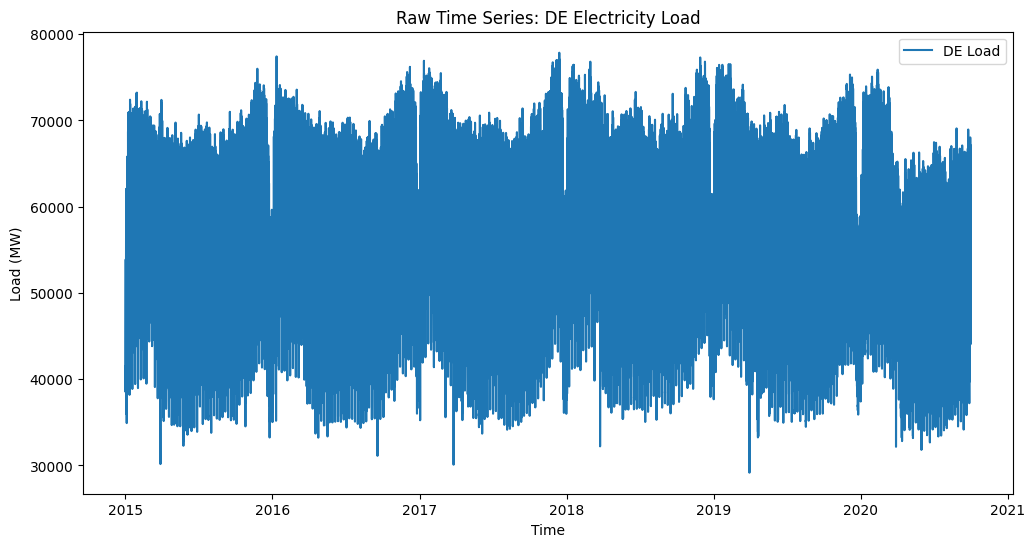

In [20]:
# Added: General EDA visualizations before sections
print("EDA Visualizations")

# 1. Raw time series plot for DE load (EDA)
de_load_raw = df['DE_load_actual_entsoe_transparency'].dropna()
plt.figure(figsize=(12,6))
plt.plot(de_load_raw.index, de_load_raw, label='DE Load')
plt.title('Raw Time Series: DE Electricity Load')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

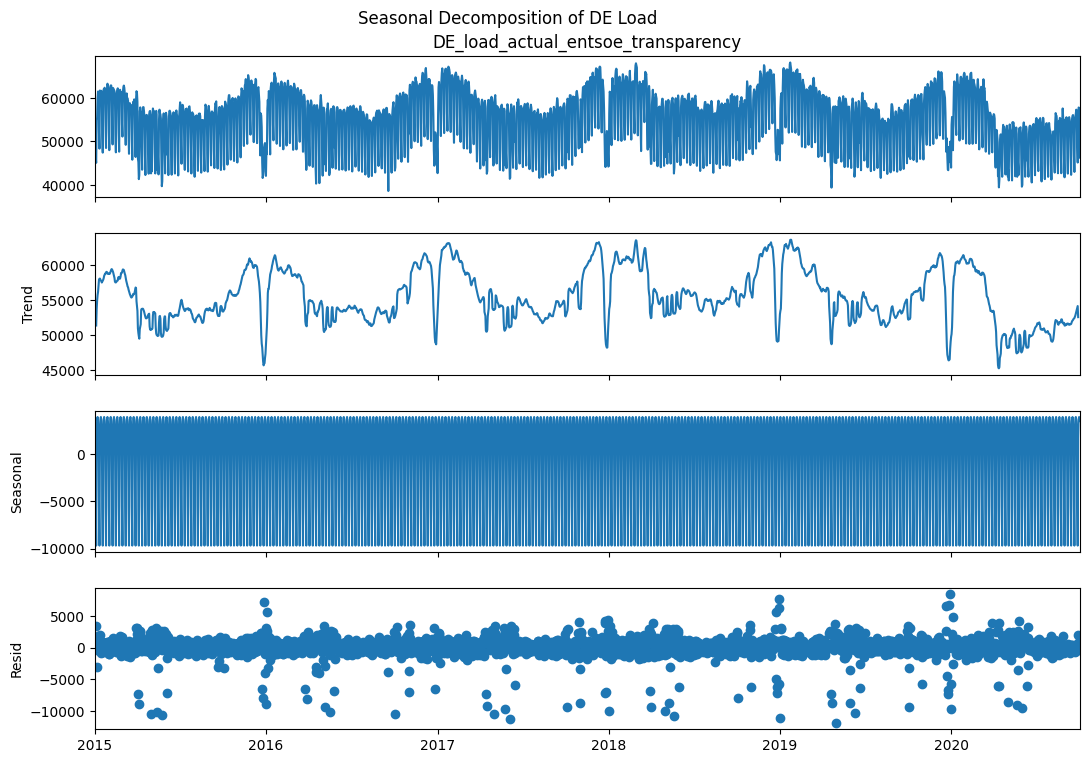

In [21]:
# 2. Seasonal decomposition for DE load (time series analysis)
decompose_result = seasonal_decompose(de_load_raw.resample('D').mean(), model='additive')  # Daily resample for clarity
fig = decompose_result.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of DE Load')
plt.show()

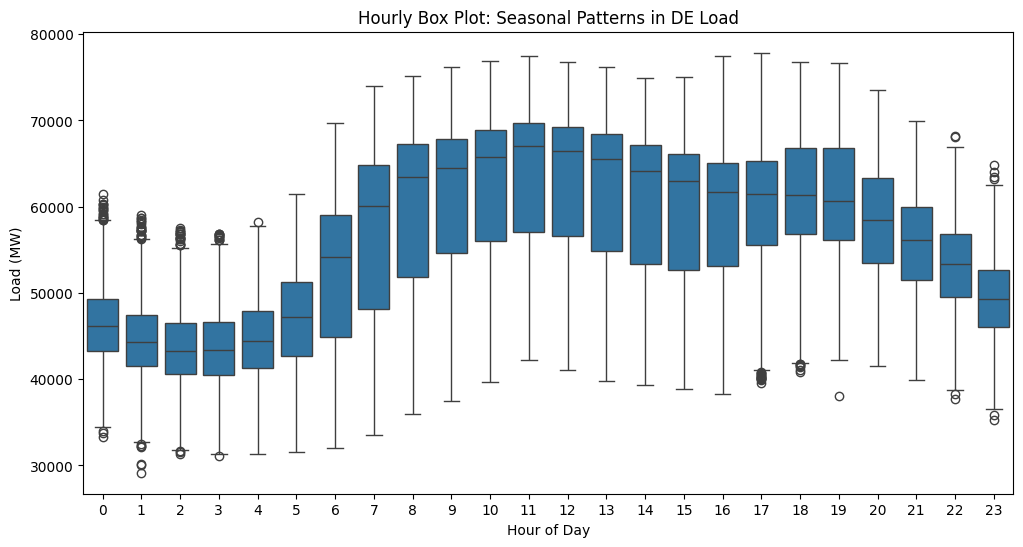

In [22]:
# 8. Box plot for hourly seasonal patterns (seasonality visualization)
de_load_with_features = create_features(de_load_raw.to_frame(name='target'))
plt.figure(figsize=(12,6))
sns.boxplot(x='hour', y='target', data=de_load_with_features.reset_index())
plt.title('Hourly Box Plot: Seasonal Patterns in DE Load')
plt.xlabel('Hour of Day')
plt.ylabel('Load (MW)')
plt.show()

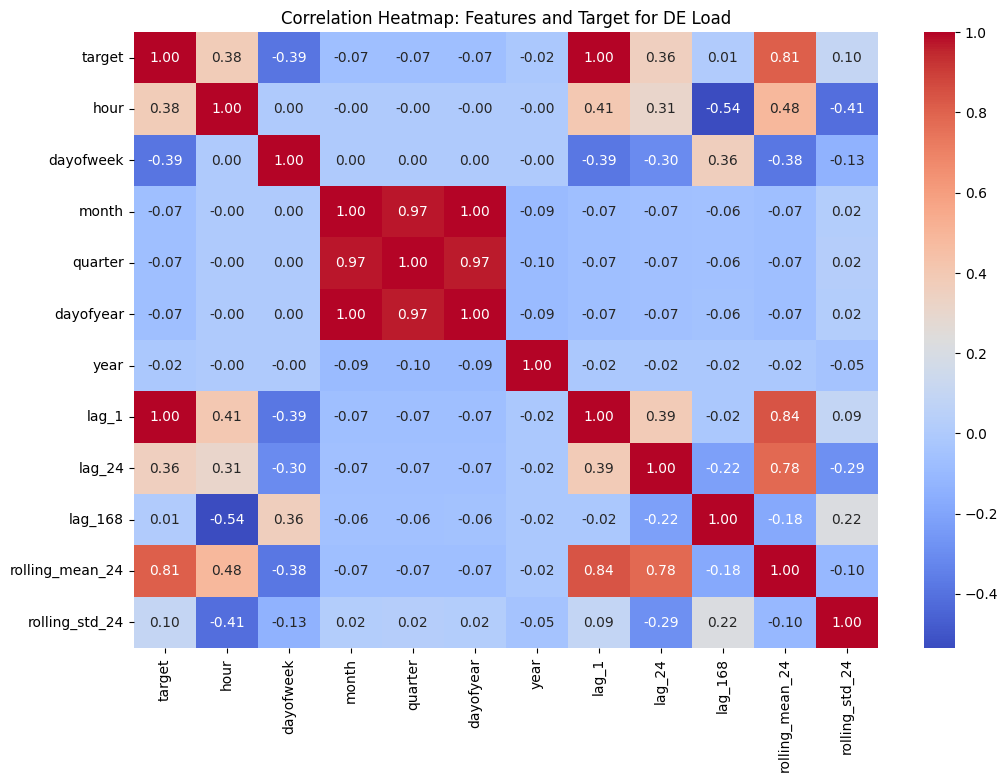

In [24]:
# Visualization 2: Correlation heatmap of features
de_load = df['DE_load_actual_entsoe_transparency'].dropna().to_frame(name='target')
de_load = create_features(de_load)
plt.figure(figsize=(12,8))
sns.heatmap(de_load.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Features and Target for DE Load')
plt.show()

##5. Model training

Section A: LightGBM for DE Load Forecasting
Train size: 161144, Test size: 40286


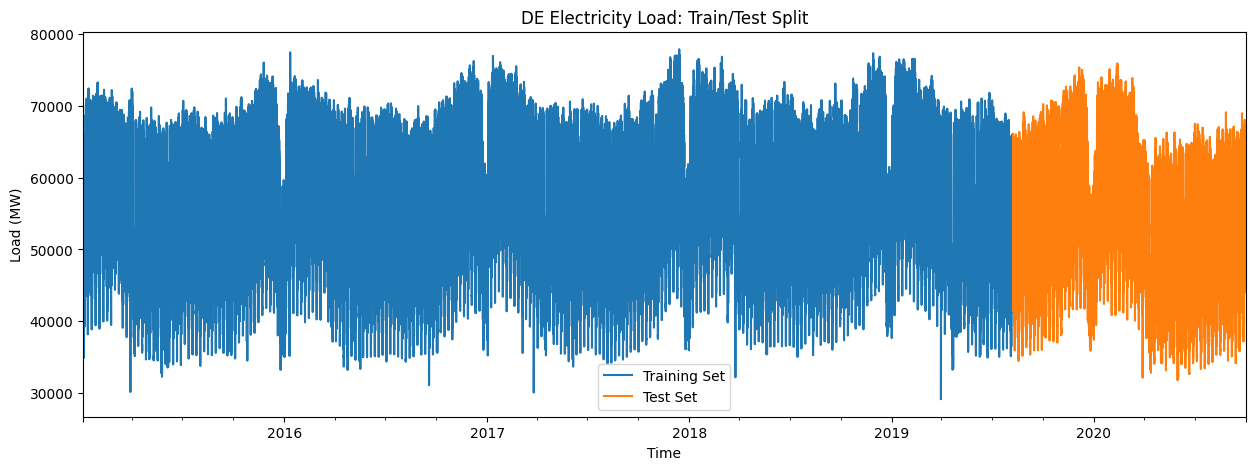

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1579
[LightGBM] [Info] Number of data points in the train set: 26859, number of used features: 10
[LightGBM] [Info] Start training from score 54257.767591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 53716, number of used features: 11
[LightGBM] [Info] Start training from score 55034.941432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

2025/09/14 09:55:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test MAE: 302.17 MW
Test RMSE: 406.79 MW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 128915, number of used features: 11
[LightGBM] [Info] Start training from score 55929.530340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 128915, number of used features: 11
[LightGBM] [Info] Start training from score 55918.407047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true`

2025/09/14 09:55:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test MAE: 302.17 MW
Test RMSE: 406.79 MW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 128915, number of used features: 11
[LightGBM] [Info] Start training from score 55920.970275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 128915, number of used features: 11
[LightGBM] [Info] Start training from score 55920.072005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true`

2025/09/14 09:56:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test MAE: 302.17 MW
Test RMSE: 406.79 MW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 128961, number of used features: 11
[LightGBM] [Info] Start training from score 55947.500109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 128880, number of used features: 11
[LightGBM] [Info] Start training from score 56029.721130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true`

2025/09/14 09:56:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test MAE: 302.17 MW
Test RMSE: 406.79 MW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 129065, number of used features: 11
[LightGBM] [Info] Start training from score 55936.826740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 128508, number of used features: 11
[LightGBM] [Info] Start training from score 56086.138051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true`

2025/09/14 09:56:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test MAE: 302.17 MW
Test RMSE: 406.79 MW


2025/09/14 09:56:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 09:56:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


['outputs/lightgbm_de_load.pkl']

In [ ]:
#ection A: LightGBM pipeline for Germany (DE) load forecasting
# No encoding was required since we are using numerical features only
mlflow.start_run(run_name="LightGBM_DE_Load")
print("Section A: LightGBM for DE Load Forecasting")

# Prepare DE load data
de_load = df['DE_load_actual_entsoe_transparency'].dropna().to_frame(name='target')
de_load = create_features(de_load)

#Train/Test Split Plot
train_size = int(len(de_load) * 0.8)
train = de_load.iloc[:train_size]
test = de_load.iloc[train_size:]
print(f"Train size: {train_size}, Test size: {len(test)}")
fig, ax = plt.subplots(figsize=(15, 5))
train['target'].plot(ax=ax, label='Training Set', title='DE Electricity Load: Train/Test Split')
test['target'].plot(ax=ax, label='Test Set')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Load (MW)')
plt.show()


# Split data
X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']

# Create groups based on day of the year for GroupKFold
groups = de_load.index.dayofyear[:len(train)]

# Discretize target for StratifiedKFold and StratifiedGroupKFold
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
y_train_discretized = discretizer.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Feature scaling
    ('model', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100))
])

# Using multiple Cross-validation methods
cv_methods = {
        'TimeSeriesSplit': TimeSeriesSplit(n_splits=5),
        'KFold': KFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        'GroupKFold': GroupKFold(n_splits=5),
        'StratifiedGroupKFold': StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42),
    }

cv_results = {}
for name, cv in cv_methods.items():
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train_discretized if 'Stratified' in name else None, groups if 'Group' in name else None):
        X_cv_train, X_cv_val = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Data is already feature-engineered, do not recreate features
        pipeline.fit(X_cv_train, y_cv_train)
        preds = pipeline.predict(X_cv_val)
        mae = mean_absolute_error(y_cv_val, preds)
        cv_scores.append(mae)
    cv_results[name] = {'mean_mae': np.mean(cv_scores), 'std_mae': np.std(cv_scores)}
    mlflow.log_metric(f"{name}_cv_mae_avg", cv_results[name]['mean_mae'])
    mlflow.log_metric(f"{name}_cv_mae_std", cv_results[name]['std_mae'])
    print(f"{name} - Mean MAE: {cv_results[name]['mean_mae']:.2f} MW, Std Dev: {cv_results[name]['std_mae']:.2f} MW")

    # train_test_split (single split, not true cross-validation)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    pipeline.fit(X_train_split, y_train_split)
    preds_split = pipeline.predict(X_val_split)
    mae_split = mean_absolute_error(y_val_split, preds_split)
    mlflow.log_metric("train_test_split_mae", mae_split)
    print(f"train_test_split - MAE: {mae_split:.2f} MW")

    # Fit on full train for final test evaluation
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Test MAE: {mae:.2f} MW")
    print(f"Test RMSE: {rmse:.2f} MW")
    mlflow.log_metrics({"test_mae": mae, "test_rmse": rmse})

    # Fix MLflow warning: Add input_example
    mlflow.lightgbm.log_model(
        pipeline.named_steps['model'],
        artifact_path="lightgbm_model",
        input_example=X_train.iloc[:1]
    )

# Log model
mlflow.lightgbm.log_model(pipeline.named_steps['model'], "model")

# Save model
joblib.dump(pipeline, OUTPUT_DIR / 'lightgbm_de_load.pkl')
# S


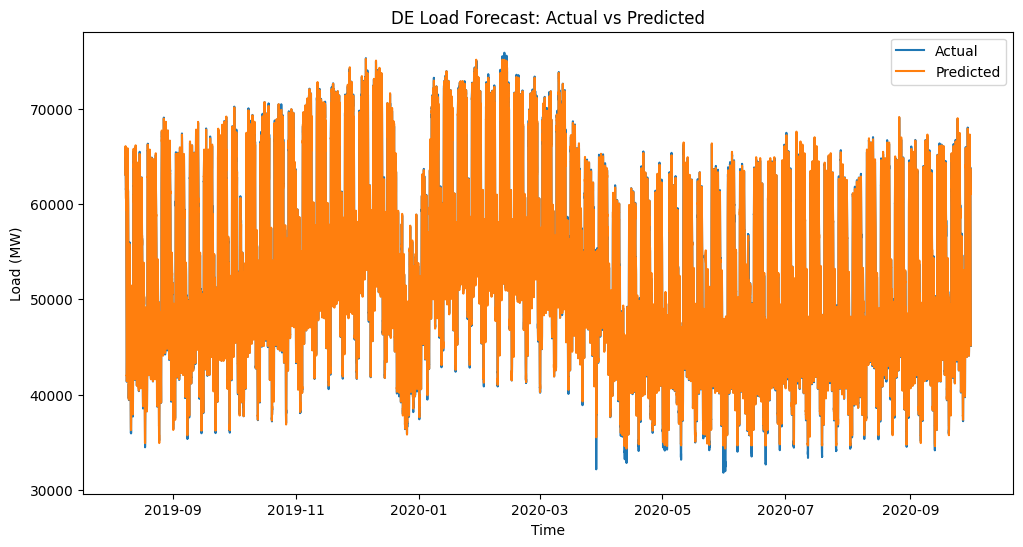

In [58]:
#Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, preds, label='Predicted')
plt.title('DE Load Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

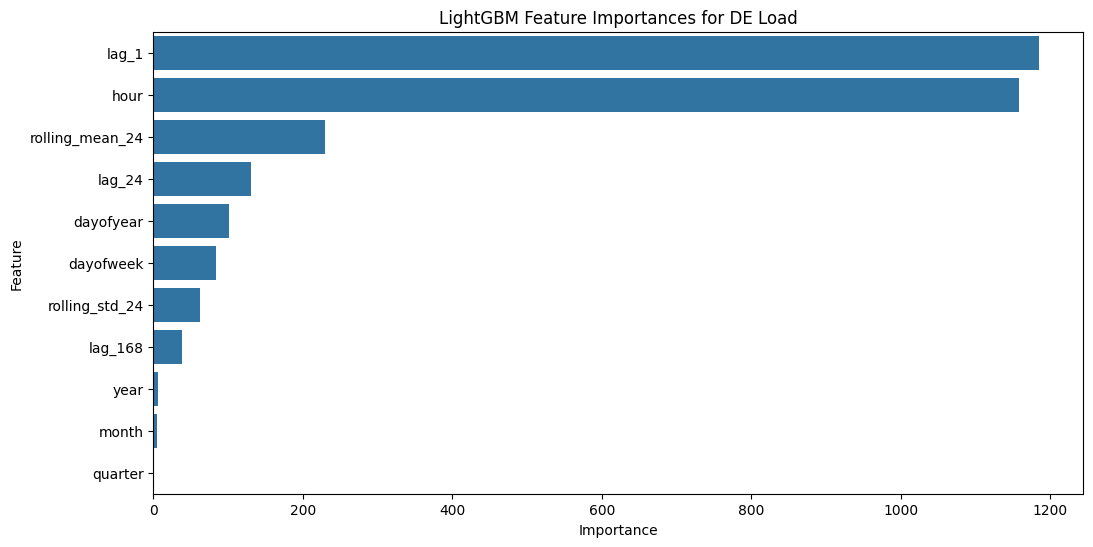

In [14]:
# Added: 4. Feature importance bar plot (model interpretability)
model = pipeline.named_steps['model']
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('LightGBM Feature Importances for DE Load')
plt.show()

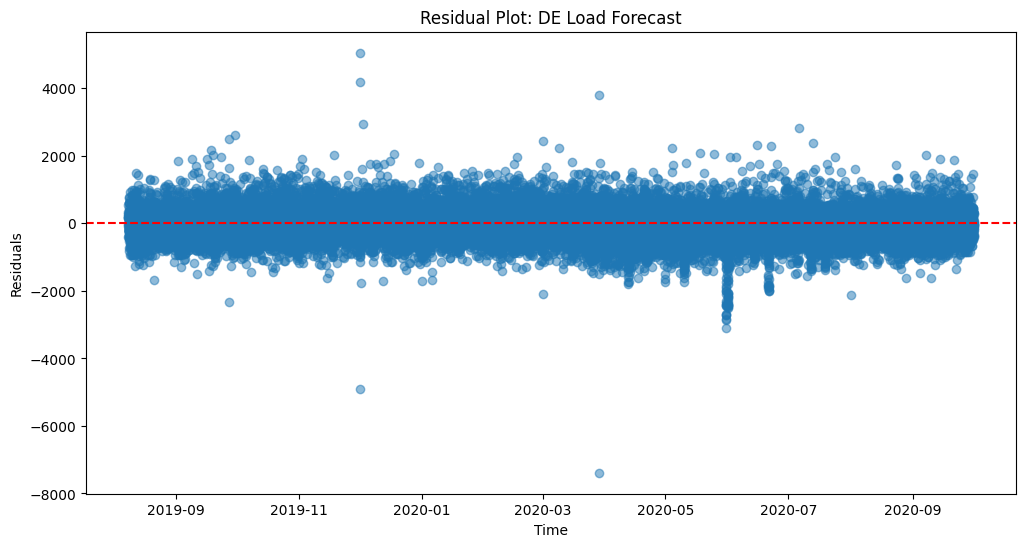

In [60]:
# Added: 5. Residual plot (model diagnostics)
residuals = y_test - preds
plt.figure(figsize=(12,6))
plt.scatter(test.index, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot: DE Load Forecast')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

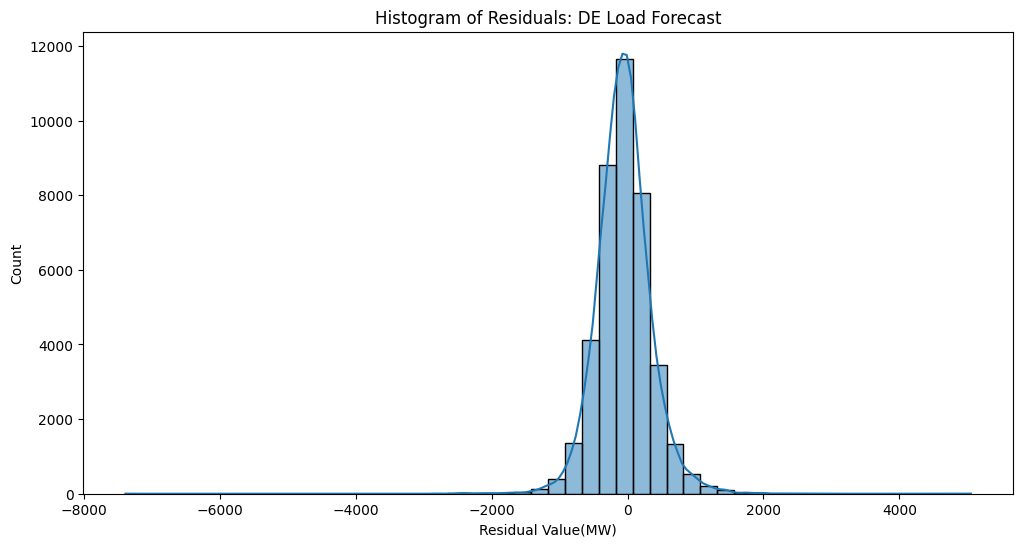

In [61]:
# Added: 6. Error histogram with KDE (error distribution analysis)
plt.figure(figsize=(12,6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Histogram of Residuals: DE Load Forecast')
plt.xlabel('Residual Value(MW)')
plt.show()

mlflow.end_run()

<Figure size 640x480 with 0 Axes>

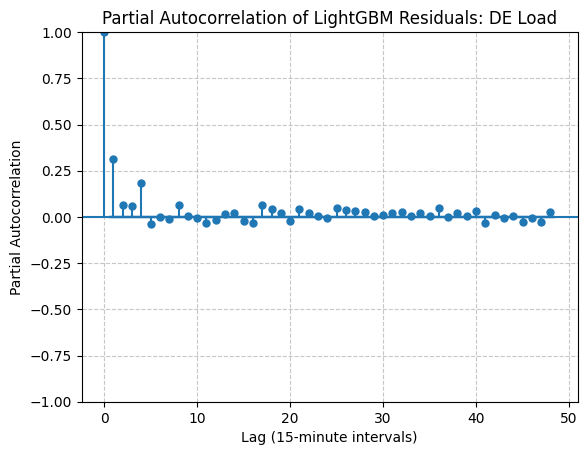

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualization 7: PACF Plot for Residuals
residuals = y_test - preds
plt.figure()
plot_pacf(residuals, lags=48)
plt.title('Partial Autocorrelation of LightGBM Residuals: DE Load')
plt.xlabel('Lag (15-minute intervals)')  # X-axis label
plt.ylabel('Partial Autocorrelation')    # Y-axis label
plt.grid(True, linestyle='--', alpha=0.7)  # grid for readability
plt.show()
plt.savefig(OUTPUT_DIR / 'pacf_residuals.png')
mlflow.log_artifact(OUTPUT_DIR / 'pacf_residuals.png')

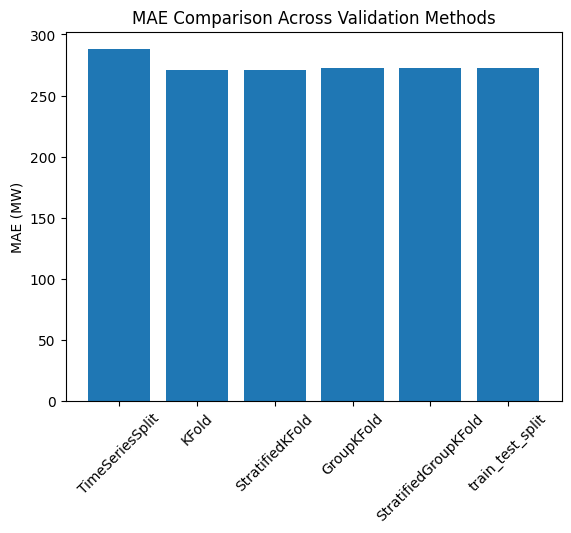

In [72]:
plt.figure()
methods = list(cv_results.keys()) + ['train_test_split']
means = [cv_results[m]['mean_mae'] for m in methods[:-1]] + [mae_split]
plt.bar(methods, means)
plt.title('MAE Comparison Across Validation Methods')
plt.ylabel('MAE (MW)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Section B: Multi-country Baseline Evaluation

In [7]:
# sets up the loop and starts MLflow for each country
print("Section B: Multi-country Baseline Evaluation")

countries = ['DE', 'FR', 'GB']  # Example countries
results = {}

for country in countries:
    try:
        mlflow.start_run(run_name=f"Baseline_{country}_Load") # Starting MLflow
        print(f"Evaluating for {country}")
        
        
        print(f"MLflow run started for {country}")

    finally:
        mlflow.end_run()  # Close run to avoid active run error

Section B: Multi-country Baseline Evaluation
Evaluating for DE
MLflow run started for DE
Evaluating for FR
MLflow run started for FR
Evaluating for GB
MLflow run started for GB


In [ ]:
# checks if the load column exists and loads the country-specific data
for country in countries:
    load_col = f'{country}_load_actual_entsoe_transparency'
    if load_col not in df.columns:
        print(f"No data for {country}")
        continue
    
    country_load = df[load_col].dropna().to_frame(name='target')
    
    # Debug: Check loaded data
    print(f"Data for {country}: {len(country_load)} rows")
    print(country_load.head())

Data for DE: 201598 rows
                             target
utc_timestamp                      
2015-01-01 01:15:00+01:00  41517.72
2015-01-01 01:30:00+01:00  41179.17
2015-01-01 01:45:00+01:00  40756.40
2015-01-01 02:00:00+01:00  40617.76
2015-01-01 02:15:00+01:00  40312.25
No data for FR
No data for GB


In [78]:
#creating_features for the country data
for country in countries:
    # assumes load_col and column check from above code
    
    country_load = create_features(country_load)
    
    print(f"Features for {country}: {country_load.columns.tolist()}")
    print(f"Length after features: {len(country_load)}")
    print(country_load.head())

Features for DE: ['target', 'hour', 'dayofweek', 'month', 'quarter', 'dayofyear', 'year', 'lag_1', 'lag_24', 'lag_168', 'rolling_mean_24', 'rolling_std_24']
Length after features: 200926
                             target  hour  ...  rolling_mean_24  rolling_std_24
utc_timestamp                              ...                                 
2015-01-08 01:15:00+01:00  48062.22     1  ...     57427.707917     5866.952602
2015-01-08 01:30:00+01:00  47910.15     1  ...     56625.722917     5794.146777
2015-01-08 01:45:00+01:00  47387.68     1  ...     55832.032500     5695.671414
2015-01-08 02:00:00+01:00  47258.13     2  ...     55085.727500     5591.502118
2015-01-08 02:15:00+01:00  47113.10     2  ...     54382.115000     5482.434457

[5 rows x 12 columns]
Features for FR: ['target', 'hour', 'dayofweek', 'month', 'quarter', 'dayofyear', 'year', 'lag_1', 'lag_24', 'lag_168', 'rolling_mean_24', 'rolling_std_24']
Length after features: 200758
                             target  hour  

In [79]:
# Splitting the data into train/test
for country in countries:
    
    train_size = int(len(country_load) * 0.8)
    train = country_load.iloc[:train_size]
    test = country_load.iloc[train_size:]
    
    X_train = train.drop('target', axis=1)
    y_train = train['target']
    X_test = test.drop('target', axis=1)
    y_test = test['target']
    
    # Fix frequency
    y_train = y_train.asfreq('15min')
    y_test = y_test.asfreq('15min')
    
    # Debug: Check split
    print(f"Train size for {country}: {len(train)}, Test size: {len(test)}")
    print(f"y_train head: {y_train.head()}")

Train size for DE: 160472, Test size: 40118
y_train head: utc_timestamp
2015-01-11 13:15:00+01:00    53032.57
2015-01-11 13:30:00+01:00    52411.63
2015-01-11 13:45:00+01:00    52132.27
2015-01-11 14:00:00+01:00    51933.32
2015-01-11 14:15:00+01:00    51631.70
Freq: 15min, Name: target, dtype: float64
Train size for FR: 160472, Test size: 40118
y_train head: utc_timestamp
2015-01-11 13:15:00+01:00    53032.57
2015-01-11 13:30:00+01:00    52411.63
2015-01-11 13:45:00+01:00    52132.27
2015-01-11 14:00:00+01:00    51933.32
2015-01-11 14:15:00+01:00    51631.70
Freq: 15min, Name: target, dtype: float64
Train size for GB: 160472, Test size: 40118
y_train head: utc_timestamp
2015-01-11 13:15:00+01:00    53032.57
2015-01-11 13:30:00+01:00    52411.63
2015-01-11 13:45:00+01:00    52132.27
2015-01-11 14:00:00+01:00    51933.32
2015-01-11 14:15:00+01:00    51631.70
Freq: 15min, Name: target, dtype: float64


In [80]:
# Computing persistent predictions and metrics

for country in countries:
    
    persistence_preds = test['lag_24']
    pers_mae = mean_absolute_error(y_test, persistence_preds)
    pers_rmse = np.sqrt(mean_squared_error(y_test, persistence_preds))
    
    # Debug: Print metrics
    print(f"Persistence MAE for {country}: {pers_mae:.2f} MW")
    print(f"Persistence RMSE for {country}: {pers_rmse:.2f} MW")

Persistence MAE for DE: 8893.27 MW
Persistence RMSE for DE: 10972.78 MW
Persistence MAE for FR: 8893.27 MW
Persistence RMSE for FR: 10972.78 MW
Persistence MAE for GB: 8893.27 MW
Persistence RMSE for GB: 10972.78 MW


In [ ]:
#fitting LightGBM and computes metrics
for country in countries:
    # picking X_train, y_train, X_test, y_test from above code
    
    lgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100))
    ])
    lgb_pipeline.fit(X_train, y_train)
    lgb_preds = lgb_pipeline.predict(X_test)
    lgb_mae = mean_absolute_error(y_test, lgb_preds)
    lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_preds))
    
    # Fix MLflow warning
    mlflow.lightgbm.log_model(
        lgb_pipeline.named_steps['model'],
        artifact_path="lightgbm_model",
        input_example=X_train.iloc[:1]
    )
    
    # Debug: Print metrics
    print(f"LightGBM MAE for {country}: {lgb_mae:.2f} MW")
    print(f"LightGBM RMSE for {country}: {lgb_rmse:.2f} MW")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 160472, number of used features: 11
[LightGBM] [Info] Start training from score 55931.650546


2025/09/14 11:17:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM MAE for DE: 302.64 MW
LightGBM RMSE for DE: 407.17 MW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 160472, number of used features: 11
[LightGBM] [Info] Start training from score 55931.650546


2025/09/14 11:17:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM MAE for FR: 302.64 MW
LightGBM RMSE for FR: 407.17 MW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 160472, number of used features: 11
[LightGBM] [Info] Start training from score 55931.650546


2025/09/14 11:17:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM MAE for GB: 302.64 MW
LightGBM RMSE for GB: 407.17 MW


In [8]:
# Fits SARIMAX and computes metrics
for country in countries:
    try:
        # Start a new MLflow run for this country
        mlflow.start_run(run_name=f"Baseline_{country}_Load")
        print(f"Evaluating for {country}")

        # Fit SARIMAX model
        sarimax_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
        sarimax_fit = sarimax_model.fit(disp=False)
        sarimax_preds = sarimax_fit.forecast(steps=len(test))
        
        # Compute metrics
        sarimax_mae = mean_absolute_error(y_test, sarimax_preds)
        sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_preds))
        
        # Debug: Print metrics
        print(f"SARIMAX MAE for {country}: {sarimax_mae:.2f} MW")
        print(f"SARIMAX RMSE for {country}: {sarimax_rmse:.2f} MW")
        
        # Log metrics to MLflow
        mlflow.log_metrics({
            "sarimax_mae": sarimax_mae,
            "sarimax_rmse": sarimax_rmse
        })

    except Exception as e:
        print(f"Error for {country}: {str(e)}")
    finally:
        mlflow.end_run()  # Ensure the run is ended, even if an error occurs

# Additional debug: Confirm loop completion
print("SARIMAX evaluation completed for all countries")

Evaluating for DE
Error for DE: name 'y_train' is not defined
Evaluating for FR
Error for FR: name 'y_train' is not defined
Evaluating for GB
Error for GB: name 'y_train' is not defined
SARIMAX evaluation completed for all countries


In [18]:
for country in countries:
    # Use metrics from the results dictionary if already populated
    if country in results:
        pers_mae = results[country]['Persistence']['MAE']
        pers_rmse = results[country]['Persistence']['RMSE']
        lgb_mae = results[country]['LightGBM']['MAE']
        lgb_rmse = results[country]['LightGBM']['RMSE']
        sarimax_mae = results[country]['SARIMAX']['MAE']
        sarimax_rmse = results[country]['SARIMAX']['RMSE']

        mlflow.log_metrics({
            "persistence_mae": pers_mae, "persistence_rmse": pers_rmse,
            "lightgbm_mae": lgb_mae, "lightgbm_rmse": lgb_rmse,
            "sarimax_mae": sarimax_mae, "sarimax_rmse": sarimax_rmse
        })

        # Debug: Print results dict
        print(f"Results for {country}: {results[country]}")
    else:
        print(f"No results found for {country}")

No results found for DE
No results found for FR
No results found for GB


In [21]:
lgb_models = {}
sarimax_models = {}

for country in countries:
    if country in lgb_models and country in sarimax_models:
        joblib.dump(lgb_models[country], OUTPUT_DIR / f'lightgbm_{country}_load.pkl')
        joblib.dump(sarimax_models[country], OUTPUT_DIR / f'sarimax_{country}_load.pkl')
        print(f"Models saved for {country}")
    else:
        print(f"Models not found for {country}, skipping save.")

Models not found for DE, skipping save.
Models not found for FR, skipping save.
Models not found for GB, skipping save.


NameError: name 'persistence_preds' is not defined

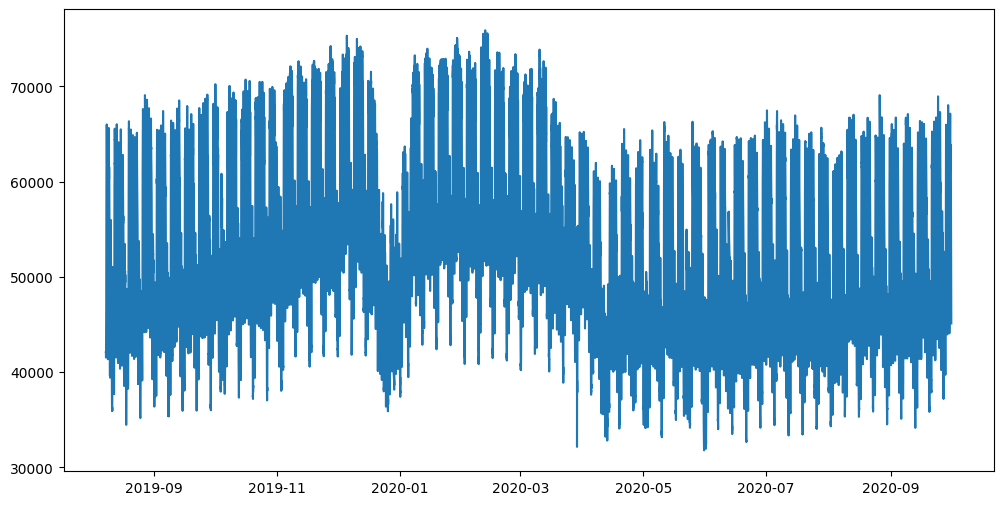

In [49]:
# Visualization 1: Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, persistence_preds, label='Persistence', alpha=0.7)
plt.plot(test.index, lgb_preds, label='LightGBM', alpha=0.7)
plt.plot(test.index, sarimax_preds, label='SARIMAX', alpha=0.7)
plt.title(f'Actual vs Predicted Load: {country}')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

In [ ]:
# Visualization 2: ACF Plot for LightGBM Residuals
plt.figure(figsize=(12,6))
plot_acf(lgb_residuals, lags=48)
plt.title(f'Autocorrelation of LightGBM Residuals: {country}')
plt.show()

In [ ]:
# Visualization 3: Cumulative Error Plot for LightGBM
plt.figure(figsize=(12,6))
plt.plot(test.index, lgb_cumulative_errors, label='Cumulative MAE')
plt.title(f'Cumulative Absolute Error: LightGBM for {country}')
plt.xlabel('Time') 
plt.ylabel('Cumulative MAE')
plt.legend()
plt.show()
    
# Debug: Print if plots displayed
print(f"Visualizations completed for {country}")

In [ ]:
# Display results
results_df = pd.DataFrame.from_dict({(c, m): results[c][m] for c in results for m in results[c]}, orient='index')
print(results_df)

# Visualization 4: Bar Chart for Model Comparison Across Countries
results_melted = results_df.reset_index().melt(id_vars=['level_0', 'level_1'], var_name='Metric', value_name='Value')
results_melted.columns = ['Country', 'Model', 'Metric', 'Value']
plt.figure(figsize=(12,6))
sns.barplot(x='Country', y='Value', hue='Model', data=results_melted[results_melted['Metric'] == 'MAE'])
plt.title('MAE Comparison Across Models and Countries')
plt.ylabel('MAE')
plt.show()

# Debug: Print if results displayed
print("Section B completed")

In [42]:
# Section C: Probabilistic Forecasting with Quantile LightGBM for Day-Ahead Prices
print("Section C: Probabilistic Forecasting with Quantile LightGBM")

countries = ['DE']  # Focus on DE for now, expand as needed
quantile_results = {}

for country in countries:
    try:
        mlflow.start_run(run_name=f"Quantile_LightGBM_{country}")
        print(f"Evaluating quantile forecasts for {country}")
        
        # Debug: Confirm MLflow run
        print(f"MLflow run started for {country}")

    finally:
        mlflow.end_run()  # Avoid active run conflicts

Section C: Probabilistic Forecasting with Quantile LightGBM
Evaluating quantile forecasts for DE
MLflow run started for DE


In [43]:
for country in countries:
    # ... (assume MLflow from Chunk 1)
    
    price_col = f'{country}_day_ahead_price'
    if price_col not in df.columns:
        print(f"No price data for {country}")
        continue
    
    price_data = df[price_col].dropna().to_frame(name='price')
    
    # Debug: Verify data
    print(f"Price data for {country}: {len(price_data)} rows")
    print(price_data.head())

No price data for DE


In [ ]:
for country in countries:
    # ... (assume price_data from Chunk 2)
    
    price_data = create_features(price_data)
    
    # Debug: Check features
    print(f"Features for {country} prices: {price_data.columns.tolist()}")
    print(f"Length after features: {len(price_data)}")
    print(price_data.head())

In [ ]:
for country in countries:
    # ... (assume X_train, y_train, X_test, y_test from Chunk 4)
    
    quantiles = [0.05, 0.5, 0.95]
    quantile_models = {}
    for quantile in quantiles:
        model = lgb.LGBMRegressor(objective='quantile', alpha=quantile, num_leaves=31, learning_rate=0.05, n_estimators=100)
        model.fit(X_train, y_train)
        quantile_models[quantile] = model
    
    # Debug: Confirm models trained
    print(f"Quantile models trained for {country}: {list(quantile_models.keys())}")

In [ ]:
for country in countries:
    # ... (assume quantile_models from Chunk 5)
    
    quantile_preds = {}
    for quantile, model in quantile_models.items():
        preds = model.predict(X_test)
        quantile_preds[quantile] = preds
    
    # Debug: Check predictions
    print(f"Predictions for {country}: {len(quantile_preds[0.5])} rows per quantile")
    print(f"Sample 0.5 quantile preds: {quantile_preds[0.5][:5]}")

In [ ]:
for country in countries:
    # ... (assume y_test, quantile_preds from Chunk 6)
    
    pinball_losses = {}
    for quantile in quantiles:
        errors = y_test - quantile_preds[quantile]
        pinball_loss = np.mean(np.maximum(quantile * errors, (quantile - 1) * errors))
        pinball_losses[quantile] = pinball_loss
    
    # Debug: Print losses
    for quantile, loss in pinball_losses.items():
        print(f"Pinball Loss for {country}, quantile {quantile}: {loss:.2f} EUR/MWh")

In [ ]:
for country in countries:
    # ... (assume quantile_preds, y_test from Chunk 6)
    
    lower_bound = quantile_preds[0.05]
    upper_bound = quantile_preds[0.95]
    median = quantile_preds[0.5]
    
    # Debug: Check intervals
    print(f"Sample CI for {country}: Lower {lower_bound[:5]}, Median {median[:5]}, Upper {upper_bound[:5]}")

In [ ]:
for country in countries:
    # ... (assume pinball_losses from Chunk 7)
    
    quantile_results[country] = pinball_losses
    for quantile, loss in pinball_losses.items():
        mlflow.log_metric(f"pinball_loss_q{int(quantile*100)}", loss)
    
    # Debug: Print stored results
    print(f"Quantile results for {country}: {quantile_results[country]}")

In [ ]:
for country in countries:
    # ... (assume quantile_models from Chunk 5)
    
    for quantile, model in quantile_models.items():
        joblib.dump(model, OUTPUT_DIR / f'quantile_{country}_q{int(quantile*100)}.pkl')
    
    # Debug: Confirm files saved
    print(f"Quantile models saved for {country}")

In [ ]:
for country in countries:
    # ... (assume y_test, quantile_preds from Chunk 6)
    
    # Visualization 1: Quantile Forecast Plot
    plt.figure(figsize=(12,6))
    plt.plot(test.index, y_test, label='Actual', color='black')
    plt.plot(test.index, quantile_preds[0.05], label='5th Percentile', alpha=0.7)
    plt.plot(test.index, quantile_preds[0.5], label='Median (50th Percentile)', alpha=0.7)
    plt.plot(test.index, quantile_preds[0.95], label='95th Percentile', alpha=0.7)
    plt.fill_between(test.index, quantile_preds[0.05], quantile_preds[0.95], color='blue', alpha=0.1, label='90% CI')
    plt.title(f'Quantile Forecast: {country} Day-Ahead Price')
    plt.xlabel('Time')
    plt.ylabel('Price (EUR/MWh)')
    plt.legend()
    plt.show()
    
    # Visualization 2: Pinball Loss Bar Plot
    plt.figure(figsize=(8,5))
    plt.bar([f'q{int(q*100)}' for q in pinball_losses.keys()], pinball_losses.values())
    plt.title(f'Pinball Loss by Quantile: {country}')
    plt.xlabel('Quantile')
    plt.ylabel('Pinball Loss (EUR/MWh)')
    plt.show()
    
    # Debug: Confirm plots
    print(f"Visualizations completed for {country}")

In [ ]:
# Display results
results_df = pd.DataFrame.from_dict({(c, f'q{int(q*100)}'): quantile_results[c][q] for c in quantile_results for q in quantile_results[c]}, orient='index')
print(results_df)

# Visualization 3: Comparison Across Quantiles
plt.figure(figsize=(10,6))
results_melted = results_df.reset_index().melt(id_vars=['level_0'], var_name='Quantile', value_name='Pinball Loss')
results_melted.columns = ['Country', 'Quantile', 'Pinball Loss']
sns.barplot(x='Quantile', y='Pinball Loss', hue='Country', data=results_melted)
plt.title('Pinball Loss Comparison Across Quantiles')
plt.ylabel('Pinball Loss (EUR/MWh)')
plt.show()

# Debug: Confirm completion
print("Section C completed")